# Milestone 5

In [2]:
# Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import zipfile
from matplotlib.lines import Line2D
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Import our utilities
from utils import *

# Specify global variables
RANDOM_STATE = 209
DATA_PATH = "../data/block_groups.geojson"

c:\Users\maxab\micromamba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 | Problem Statement

### 1a | Motivation



### 1b | Context

Voter turnout reflects the health of a democratic system, measuring the participation of its members in the electoral process.  However, it is widely documented that voter turnout varies significantly across demographic groups such as age, race, education, and income. Research finds that nonvoters are more likely to be younger, identify as non-White, have low education, and come from low income households ([Pew Research Group, 2023](https://www.pewresearch.org/politics/2023/07/12/voter-turnout-2018-2022/)). Further understanding these patterns is crucial for identifying barriers to participation and designing policies to improve turnout ([MIT, 2021](https://electionlab.mit.edu/research/voter-turnout)).

This project explores the predictive power of voter characteristics on voter turnout for the 2020 presidential election in the state of Massachusetts. By leveraging Census Block Group data, this study aims to uncover localized patterns that aggregate county or state-level studies ([Ansolabehere et al., 2024](https://hdsr.mitpress.mit.edu/pub/0c5ylgo1/release/2)) or individual-level studies ([Kim, 2024](https://link.springer.com/article/10.1007/s11109-022-09816-z#Sec14)) may overlook.

### 1c | Framing of the Problem

**How do different voter characteristics influence voter turnout in Massachusetts?**

## 2 | Data

### 2a | Description

To answer this question, we use voter turnout data at the Census Block level sourced from L2 Data and Redistricting Data Hub.

### 2b | Data Handling

We applied several processing steps which included:
1. Dropped observations without Census Block IDs that were instead aggregated to the County level (73,811 or ~1.60% of total voters). Disaggregating these observations necessitated the assumption that demographic characteristics are uniformly distributed across the County, which is false.
2. Aggregated the Census Block data to the Census Block Group level to reduce the high variance of registered voter counts in each observation.
3. Converted most demographic predictors from counts of voters to proportion of voters. We did this to account for differences in the number of voters that lived in each Census Block Group (a Census Block Group in a city will likely have a higher voter count than a Census Block Group in rural Massachusetts).

Our response variable is the proportion of registered voters that voted in the 2020 presidential election, denoted as `2020_turnout_pct`.

Our predictors include the total number of voters registered, mean household income, and the proportion of people with specific characteristics such as age; ethnicity; party affiliation; and language.

In [3]:
# Read in the data
voter_gdf = gpd.read_file(DATA_PATH)

# Group the variables together
registered = ["total_reg"]
income = ["mean_hh_income"]
age = ["age_18_19", "age_20_24", "age_25_29", "age_30_34", "age_35_44", 
       "age_45_54", "age_55_64", "age_65_74", "age_75_84", "age_85over"]
gender = [ "gender_m", "gender_f", "gender_unknown"] 
party = ["party_npp", "party_dem", "party_rep", "party_lib", "party_grn", 
         "party_con", "party_ain", "party_scl", "party_oth"]
ethnicity1 = ["eth1_eur", "eth1_hisp", "eth1_aa",
                "eth1_esa", "eth1_oth", "eth1_unk"]
languages = ["lang_english", "lang_spanish", "lang_portuguese",
             "lang_chinese", "lang_italian", "lang_vietnamese", 
             "lang_other", "lang_unknown"]
predictors = [*registered, *income, *age, *gender, *party, *ethnicity1, *languages]

# Best predictors identified via LASSO and permutation test
predictors_subset = ["mean_hh_income", "total_reg", 
                     "lang_unknown", "gender_f", "party_dem", 
                     "eth1_hisp", "eth1_eur", "eth1_aa", "eth1_oth",
                     "age_20_24", "age_25_29", "age_30_34", "age_45_54",]

## 3 | EDA

### 3a | Voter Turnout Distribution

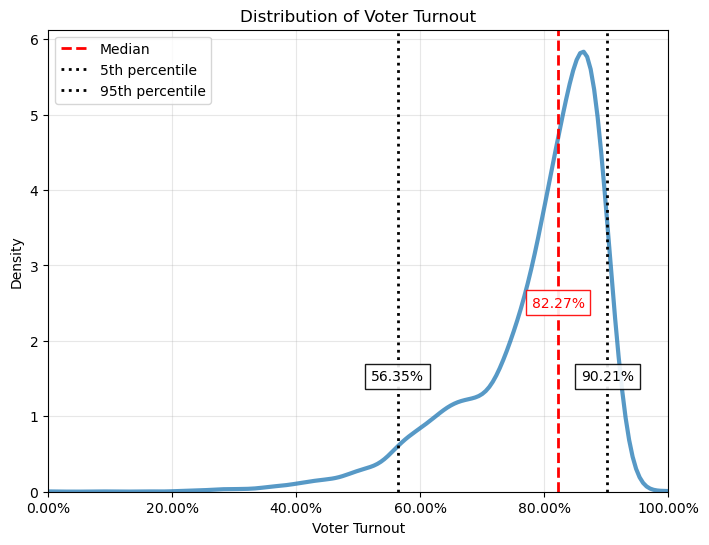

In [4]:
plot_dist(voter_gdf, "Distribution of Voter Turnout", 
         "2020_turnout_pct", "Voter Turnout", "Density",
         "{:.2%}", [0.24,0.4,0.24])

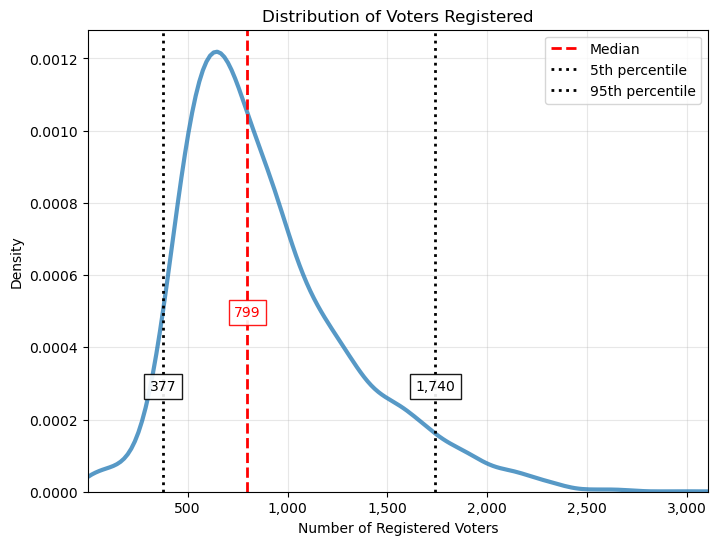

In [5]:
plot_dist(voter_gdf, "Distribution of Voters Registered", 
         "total_reg", "Number of Registered Voters", "Density",
         "{:,.0f}", [0.22,0.38,0.22])

### 3b | Voter Turnout by Income

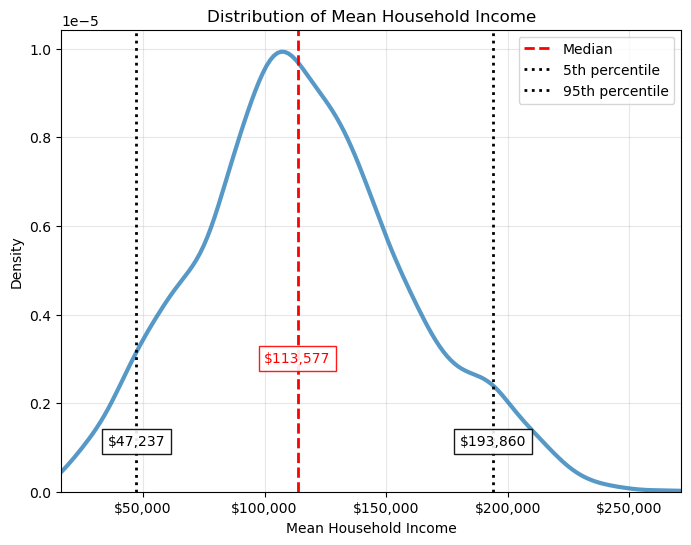

In [6]:
plot_dist(voter_gdf, "Distribution of Mean Household Income", 
         "mean_hh_income", "Mean Household Income", "Density",
         "${:,.0f}", [0.1,0.28,0.1])

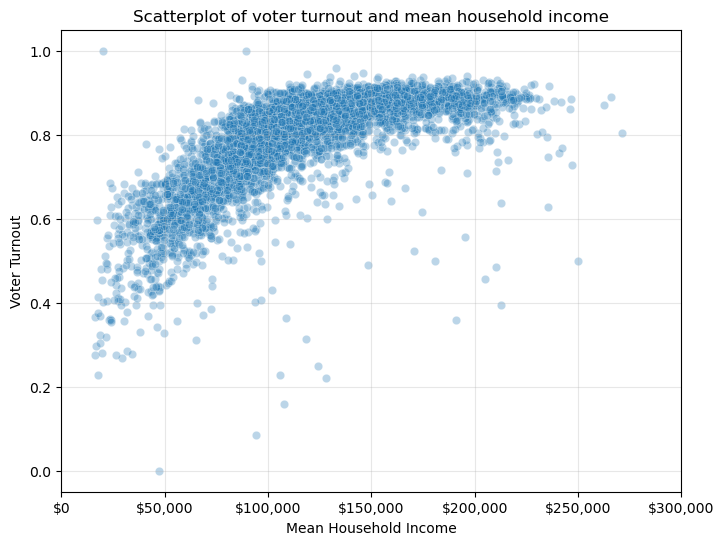

In [7]:
plot_scatter(voter_gdf, "Scatterplot of voter turnout and mean household income", 
            "mean_hh_income", "2020_turnout_pct", 
            "Mean Household Income", "Voter Turnout", "${:,.0f}")

### 3c | Voter Turnout by Ethnicity

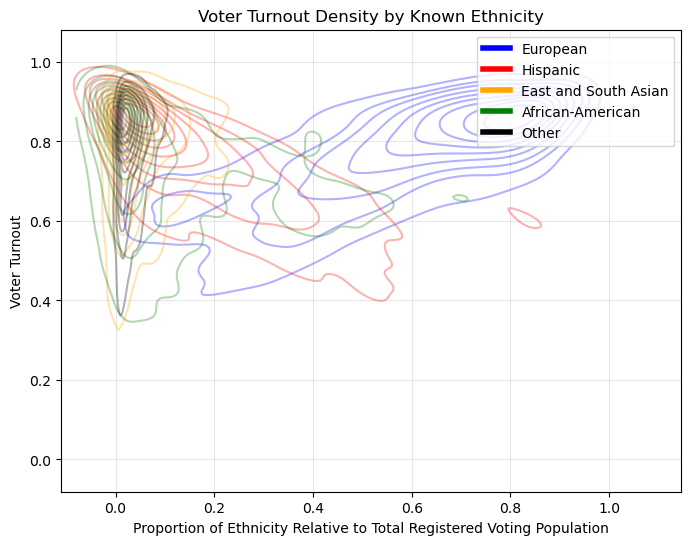

In [8]:
plot_KDE(voter_gdf, 'Voter Turnout Density by Known Ethnicity',
        ['eth1_eur','eth1_hisp', 'eth1_esa', 'eth1_aa','eth1_oth'],
        ['European', 'Hispanic',  'East and South Asian', 'African-American',  'Other'],
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Ethnicity')

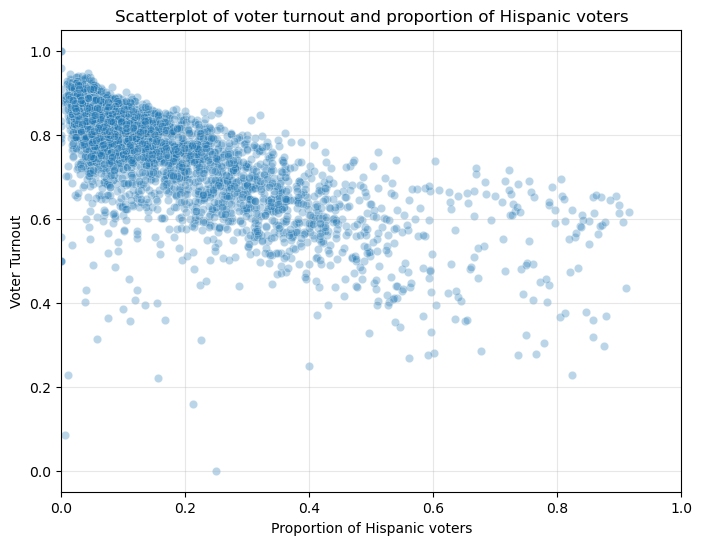

In [9]:
plot_scatter(voter_gdf, "Scatterplot of voter turnout and proportion of Hispanic voters", 
            "eth1_hisp", "2020_turnout_pct", 
            "Proportion of Hispanic voters", "Voter Turnout", "{:.1f}")

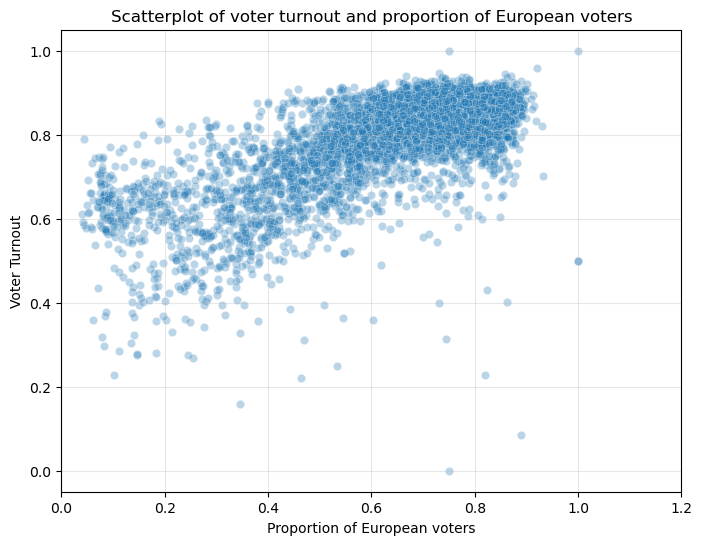

In [10]:
plot_scatter(voter_gdf, "Scatterplot of voter turnout and proportion of European voters", 
            "eth1_eur", "2020_turnout_pct", 
            "Proportion of European voters", "Voter Turnout", "{:.1f}")

### 3d | Voter Turnout by Party

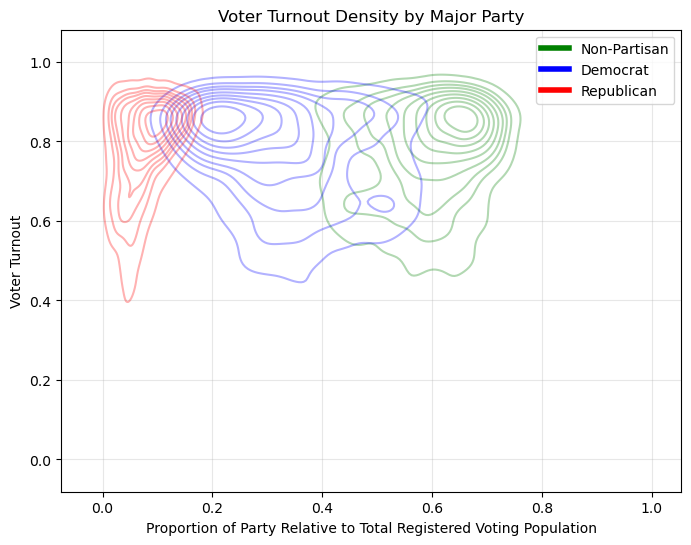

In [11]:
plot_KDE(voter_gdf, 'Voter Turnout Density by Major Party',
        ['party_npp', 'party_dem', 'party_rep'],
        ['Non-Partisan', 'Democrat', 'Republican'],
        ['green','blue','red'],
        'Party')

### 3e | Voter Turnout by Age

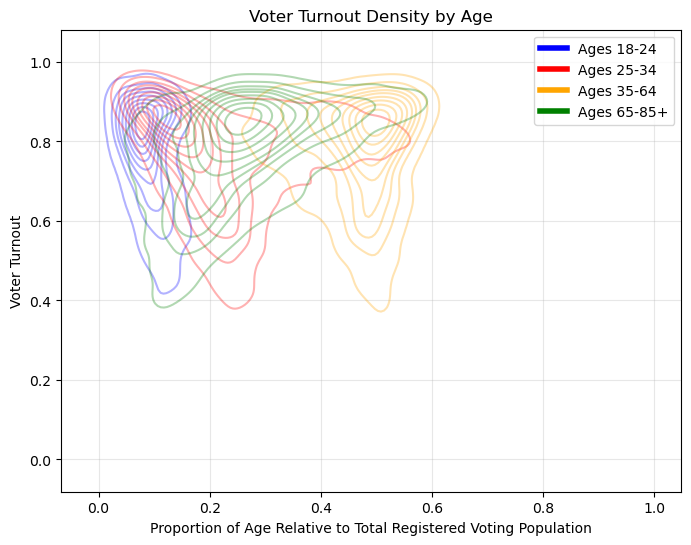

In [12]:
# Group together age bins for better visualization
voter_gdf["age_18_24"] = voter_gdf["age_18_19"]+ voter_gdf["age_20_24"]
voter_gdf["age_25_34"] = voter_gdf["age_25_29"]+ voter_gdf["age_30_34"]
voter_gdf["age_35_64"] = voter_gdf["age_35_44"]+ voter_gdf["age_45_54"]+ voter_gdf["age_55_64"]
voter_gdf["age_65_85over"] = voter_gdf["age_65_74"]+ voter_gdf["age_75_84"] + voter_gdf["age_85over"]

plot_KDE(voter_gdf, 'Voter Turnout Density by Age', 
        ['age_18_24','age_25_34', 'age_35_64', 'age_65_85over'], 
        ['Ages 18-24', 'Ages 25-34',  'Ages 35-64', 'Ages 65-85+'] ,  
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Age')

### 3f | Voter Turnout by Language

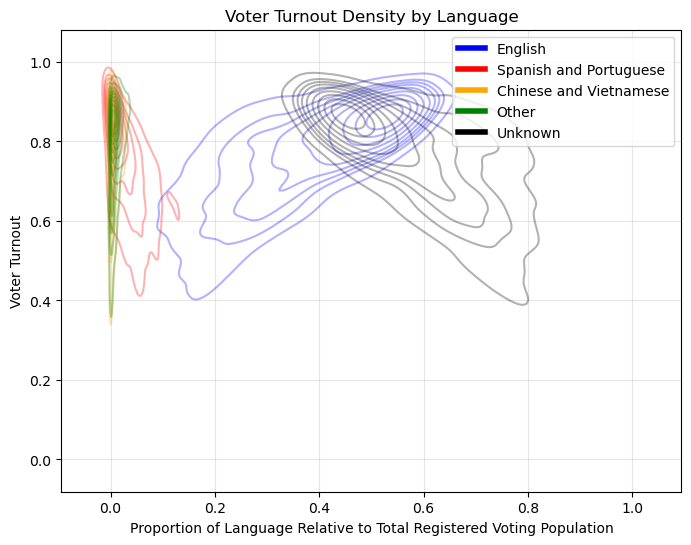

In [13]:
# Group together spanish+portuguese and vietnamese+chinese for better visualization
voter_gdf["lang_spanish_portuguese"] =voter_gdf["lang_spanish"]+voter_gdf["lang_portuguese"]
voter_gdf["lang_chinese_vietnamese"] = voter_gdf["lang_chinese"] + voter_gdf["lang_vietnamese"]
plot_KDE(voter_gdf, 'Voter Turnout Density by Language',
        ['lang_english','lang_spanish_portuguese','lang_chinese_vietnamese','lang_other', 'lang_unknown'],
        ['English', 'Spanish and Portuguese',  'Chinese and Vietnamese', 'Other', 'Unknown'], 
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Language')

## 4 | Modeling

### 4a | Linear Model

In [14]:
# Define X and y 
X = voter_gdf[PREDICTORS].copy()
y = voter_gdf["2020_turnout_pct"].copy()

# StandardScaler for total_reg and mean_hh_income
X[['total_reg','mean_hh_income']] = StandardScaler().fit_transform(X=X[['total_reg','mean_hh_income']])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)

In [17]:
# Use CV to select best alpha/lambda value lasso model
lasso_alphas = np.logspace(-4, 0, 1000)
lasso = LassoCV(alphas=lasso_alphas, cv=10, max_iter=1000).fit(X_train, y_train)
lasso_a = lasso.alpha_
print(f'LASSO with alpha={lasso_a:.5f}: {lasso.score(X_test, y_test):.3}')

# fit with CV alpha
lasso_cv = Lasso(alpha=lasso_a).fit(X_train, y_train)

# Report accuracy
y_pred_train = lasso_cv.predict(X_train)
y_pred_test = lasso_cv.predict(X_test)

# Print scores
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")


LASSO with alpha=0.00010: 0.832
	Train		Test
MSE	0.00258		0.00215
R2	0.79411		0.83210


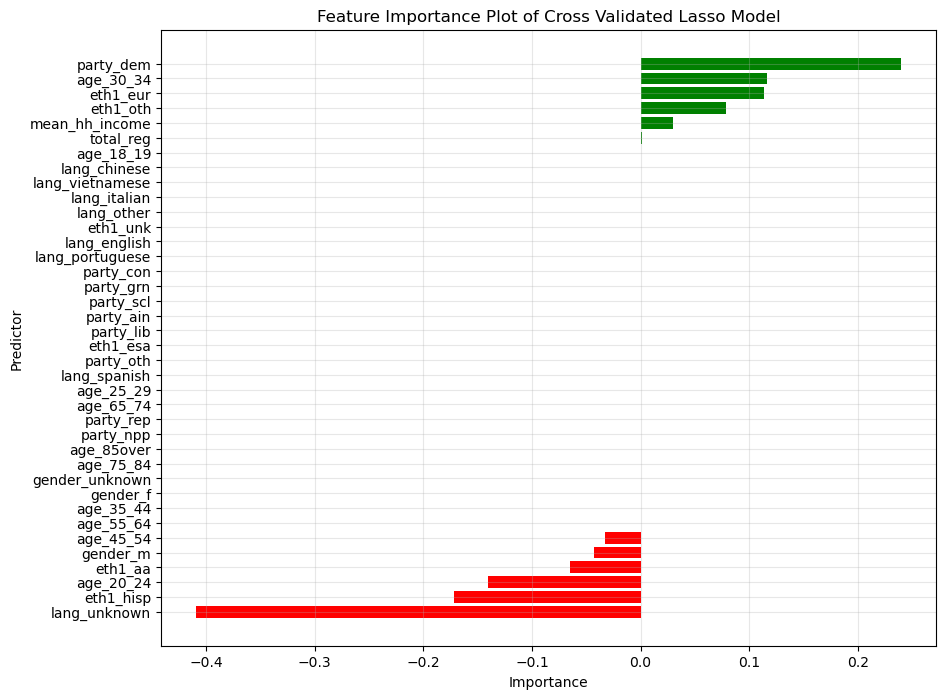

In [ ]:
coef_df_lasso = gather_plot_importance(lasso_cv, "Cross Validated Lasso Model")
predictors_lasso = coef_df_lasso[coef_df_lasso["Importance"] != 0]["Predictor"].to_list()

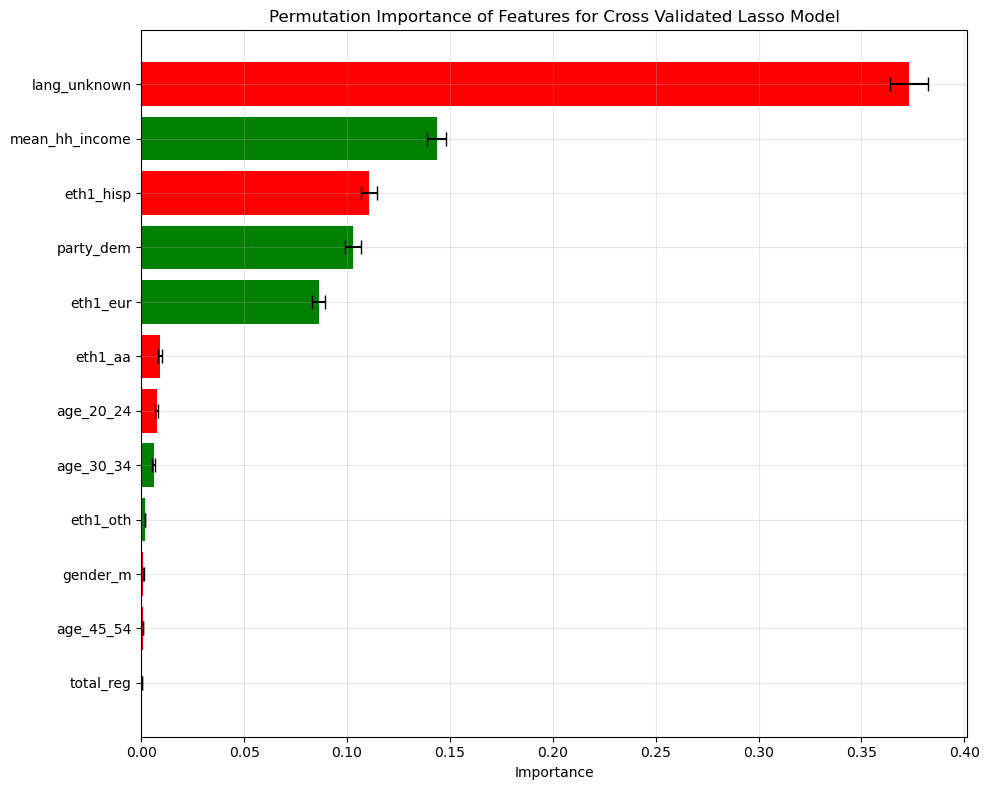

In [ ]:
# Plot permutation importance
lasso_perm = gather_perm_importance(lasso_cv, X_train, y_train, "Cross Validated Lasso Model", 100)
predictors_perm = lasso_perm["Predictor"].to_list()

### 4b | Random Forest Model

In [37]:
# Define X and y 
X = voter_gdf[PREDICTORS].copy()
y = voter_gdf["2020_turnout_pct"].copy()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)

# Specify KFold object for validation splits
kf = KFold(10, shuffle=True, random_state=RANDOM_STATE)

# Specify parameter grid to search
param_grid = {
    "n_estimators" : [50, 100, 200],
    "max_depth" : [10, 20, None],
    "min_samples_split" : [2, 10],
    "min_samples_leaf" : [1, 5],
    "max_features" : ["sqrt","log2"]
}

In [39]:
# Random search
random_search = RandomizedSearchCV(RandomForestRegressor(
    random_state=RANDOM_STATE, 
    warm_start=False), # Set this to false for deterministic behavior
        param_grid, 
        cv=kf, 
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
        n_iter=100
)
random_search.fit(X_train, y_train)

# Print best parameters:
print("The best parameters for 38 predictors are:")
for param,val in random_search.best_params_.items():
    print(f"{param}: {val}")

# Fit the random forest without tuning hyperparameters
rf_init_cv =  RandomForestRegressor(**random_search.best_params_, random_state=RANDOM_STATE)
rf_init_cv.fit(X_train, y_train)

# Report scores
y_pred_train = rf_init_cv.predict(X_train)
y_pred_test = rf_init_cv.predict(X_test)

print(f'Random Forest with all 38 predictors')
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

c:\Users\maxab\micromamba\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\maxab\micromamba\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best parameters for 38 predictors are:
n_estimators: 100
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
max_depth: 20
Random Forest with all 38 predictors
	Train		Test
MSE	0.00028		0.00145
R2	0.97736		0.88669


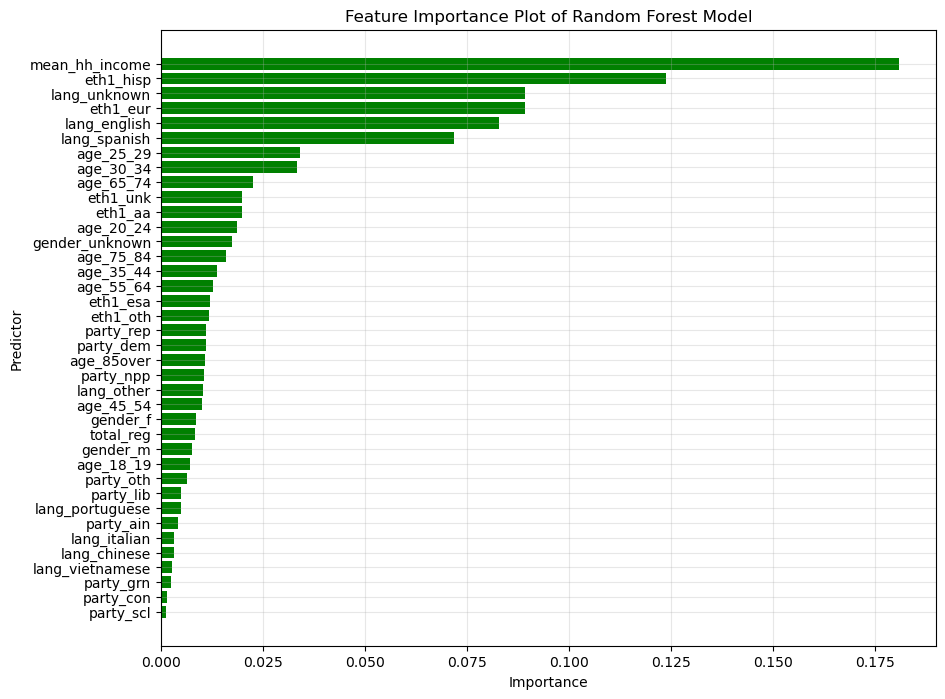

,Predictor,Importance
0,party_scl,0.001293
1,party_con,0.001609
2,party_grn,0.002435
3,lang_vietnamese,0.002773
4,lang_chinese,0.003122
5,lang_italian,0.003247
6,party_ain,0.004068
7,lang_portuguese,0.004882
8,party_lib,0.005000
9,party_oth,0.006383


In [40]:
# Plot feature importance
gather_plot_importance(rf_init_cv, "Random Forest Model")

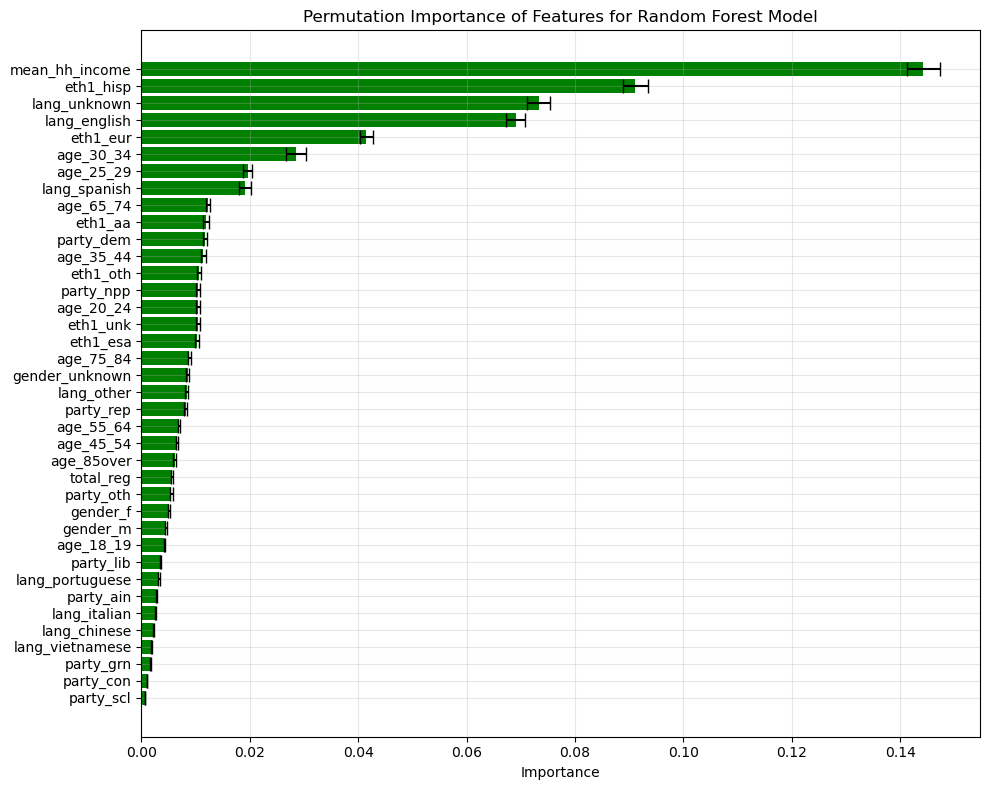

,Predictor,Permutation Importance Mean,Permutation Importance Std,Importance
37,mean_hh_income,0.144298,0.003069,0.180774
24,eth1_hisp,0.091142,0.002258,0.123732
36,lang_unknown,0.073282,0.002064,0.089211
29,lang_english,0.069073,0.001707,0.082822
23,eth1_eur,0.041505,0.001209,0.089180
4,age_30_34,0.028530,0.001770,0.033405
3,age_25_29,0.019599,0.000850,0.034115
30,lang_spanish,0.019160,0.001133,0.071880
8,age_65_74,0.012297,0.000417,0.022624
25,eth1_aa,0.011915,0.000512,0.019878


In [41]:
# Plot permutation importance for 100 iterations
gather_perm_importance(rf_init_cv, X_train, y_train, "Random Forest Model", 100)

## 5 | Results

In [ ]:
# Create SHAP explainer
explainer = shap.TreeExplainer(...)
shap_values = explainer.shap_values(X_train)

In [ ]:
# Show the SHAP beeswarm plot
shap.summary_plot(shap_values, X_train)